<a href="https://colab.research.google.com/github/Maxoo005/ml-wakacyjne-wyzwanie-2025/blob/main/2_Maksymilian_Kula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
titanic = pd.read_csv('/content/drive/MyDrive/DANE LEKCJA 1/titanic.csv')

In [49]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Moje podsumowanie listy 1, zmieniam uzupełnienie Age medianą, wpadłem na pomysl aby luki uzupełnic średnią, ale biorąc pod uwagę kombinajce biletu i płci (powiino to troche rozbic ten jeden słupek)

In [50]:
titanic['Age'] = titanic['Age'].fillna(
    titanic.groupby(['Pclass', 'Sex'])['Age'].transform('median')
)
titanic['Embarked'] = titanic['Embarked'].fillna(
    titanic['Embarked'].mode(dropna=True).iloc[0]
)
titanic = titanic.drop(columns=['Cabin'])
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1
titanic['IsAlone'] = (titanic['FamilySize'] == 1).astype(int)
titanic = titanic.drop(columns=['PassengerId', 'Name', 'Ticket'])
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,0,3,male,22.0,1,0,7.2500,S,2,0
1,1,1,female,38.0,1,0,71.2833,C,2,0
2,1,3,female,26.0,0,0,7.9250,S,1,1
3,1,1,female,35.0,1,0,53.1000,S,2,0
4,0,3,male,35.0,0,0,8.0500,S,1,1


histogram wieku wszystkich pasażerów

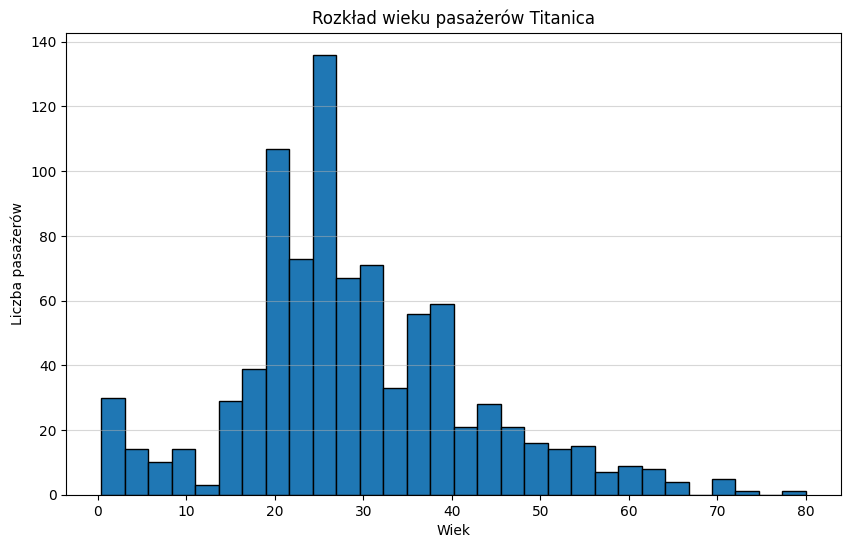

In [51]:
plt.figure(figsize=(10,6))
plt.hist(titanic['Age'], bins=30, edgecolor='black')
plt.title('Rozkład wieku pasażerów Titanica')
plt.xlabel('Wiek')
plt.ylabel('Liczba pasażerów')
plt.grid(axis='y', alpha=0.5)
plt.show()

wydaje mi sie ze jest to lepsze w porównaniu do zwykłej mediany ale idealne  chyba tez nie jest...

train test

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = titanic.drop(columns=['Survived'])
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_cols = ['Age', 'Fare', 'FamilySize']
cat_cols = ['Sex', 'Embarked', 'Pclass']

preprocessor = ColumnTransformer(
    [('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                       ('sc', StandardScaler())]), num_cols),
     ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                       ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)]
)

trenuje podany model na train i ocenia go

In [59]:
def eval_clf(clf):
    clf.fit(X_train, y_train)
    p = clf.predict(X_test)
    return {
        'acc': accuracy_score(y_test, p),
        'prec': precision_score(y_test, p, zero_division=0),
        'rec': recall_score(y_test, p, zero_division=0),
        'f1': f1_score(y_test, p, zero_division=0),
    }

Baseline DummyClassifier

In [61]:
from sklearn.dummy import DummyClassifier
baseline = Pipeline([('prep', preprocessor),
                     ('clf', DummyClassifier(strategy='most_frequent', random_state=42))])
baseline_metrics = eval_clf(baseline)
baseline_metrics

{'acc': 0.6145251396648045, 'prec': 0.0, 'rec': 0.0, 'f1': 0.0}

OCZEKIWANE WNIOSKI:   
W tym momencie z tego co czytałem to baseline powinien mieć średnie wyniki w podsumowaniu na końcu, a modele powinny go pobić krótko mówiąc

DT

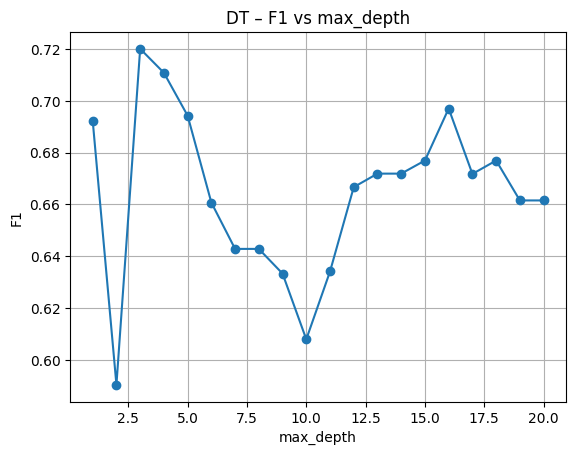

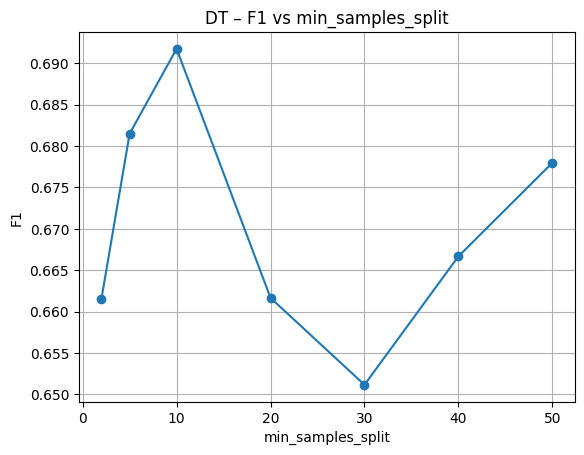

In [55]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt

rows = []
for d in range(1, 21):
    pipe = Pipeline([('prep', preprocessor),
                     ('clf', DecisionTreeClassifier(max_depth=d, random_state=42))])
    m = eval_clf(pipe); m['max_depth'] = d; rows.append(m)
dt_depth = pd.DataFrame(rows)
dt_depth_best = dt_depth.sort_values('f1', ascending=False).iloc[0]

plt.figure(); plt.plot(dt_depth['max_depth'], dt_depth['f1'], marker='o')
plt.title('DT – F1 vs max_depth'); plt.xlabel('max_depth'); plt.ylabel('F1'); plt.grid(True); plt.show()

rows = []
for mss in [2, 5, 10, 20, 30, 40, 50]:
    pipe = Pipeline([('prep', preprocessor),
                     ('clf', DecisionTreeClassifier(min_samples_split=mss, random_state=42))])
    m = eval_clf(pipe); m['min_samples_split'] = mss; rows.append(m)
dt_mss = pd.DataFrame(rows)
dt_mss_best = dt_mss.sort_values('f1', ascending=False).iloc[0]

plt.figure(); plt.plot(dt_mss['min_samples_split'], dt_mss['f1'], marker='o')
plt.title('DT – F1 vs min_samples_split'); plt.xlabel('min_samples_split'); plt.ylabel('F1'); plt.grid(True); plt.show()


KNN

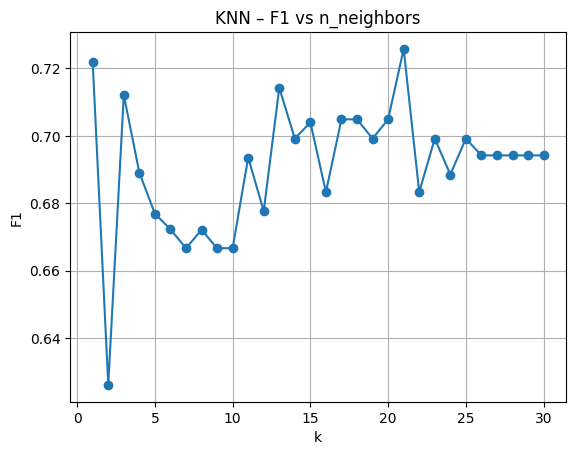

,acc,prec,rec,f1,metric
0,0.810056,0.818182,0.652174,0.725806,euclidean
2,0.810056,0.818182,0.652174,0.725806,minkowski
1,0.782123,0.800000,0.579710,0.672269,manhattan


In [56]:
from sklearn.neighbors import KNeighborsClassifier

rows = []
for k in range(1, 31):
    pipe = Pipeline([('prep', preprocessor),
                     ('clf', KNeighborsClassifier(n_neighbors=k))])
    m = eval_clf(pipe); m['k'] = k; rows.append(m)
knn_k = pd.DataFrame(rows)
knn_k_best = knn_k.sort_values('f1', ascending=False).iloc[0]

plt.figure(); plt.plot(knn_k['k'], knn_k['f1'], marker='o')
plt.title('KNN – F1 vs n_neighbors'); plt.xlabel('k'); plt.ylabel('F1'); plt.grid(True); plt.show()

rows = []
for met in ['euclidean', 'manhattan', 'minkowski']:
    pipe = Pipeline([('prep', preprocessor),
                     ('clf', KNeighborsClassifier(n_neighbors=int(knn_k_best['k']), metric=met))])
    m = eval_clf(pipe); m['metric'] = met; rows.append(m)
knn_metric = pd.DataFrame(rows).sort_values('f1', ascending=False)
knn_metric_best = knn_metric.iloc[0]
knn_metric

Próbuje podsumowac co wypada lepiej, baseline, DT czy KNN

In [57]:
summary = pd.DataFrame([
    {'model':'Baseline', **baseline_metrics},
    {'model':f'DT(best by depth={int(dt_depth_best["max_depth"])})',
     'acc':dt_depth_best['acc'], 'prec':dt_depth_best['prec'],
     'rec':dt_depth_best['rec'], 'f1':dt_depth_best['f1']},
    {'model':f'KNN(best k={int(knn_k_best["k"])}, metric={knn_metric_best["metric"]})',
     'acc':knn_metric_best['acc'], 'prec':knn_metric_best['prec'],
     'rec':knn_metric_best['rec'], 'f1':knn_metric_best['f1']},
]).sort_values('f1', ascending=False)
summary

,model,acc,prec,rec,f1
2,"KNN(best k=21, metric=euclidean)",0.810056,0.818182,0.652174,0.725806
1,DT(best by depth=3),0.804469,0.803571,0.652174,0.720000
0,Baseline,0.614525,0.000000,0.000000,0.000000


Oba modele wyraźnie pobiły baseline. KNN i DT wypadły bardzo podobnie, mają bardzo zbliżoną czułość, KNN ma troche wyższą precyzje. Moim zdaniem z tego wychodzi że KNN gwarantuje lepszy wynik